# ⚛️ VQE Ground State Simulation of H₂ with Optimizer Comparison (Noisy)

This notebook implements the **Variational Quantum Eigensolver (VQE)** to compute the **ground state energy of dihydrogen (H₂)** using a **noisy quantum simulator**. It compares multiple classical optimizers to evaluate their performance in minimizing the energy landscape of a quantum chemistry problem.

### Key Features:
- **Molecular Setup**: Constructs the molecular Hamiltonian for H₂ using the STO-3G basis set.
- **Excitation Ansatz**: Uses a UCC-style ansatz incorporating both **single and double excitations**.
- **Optimizer Evaluation**:
  - Runs the VQE algorithm using a range of optimizers defined in `vqe_utils.OPTIMIZERS`.
  - Tracks and compares convergence behavior across optimizers.
- **Ground State Analysis**:
  - Identifies the optimizer yielding the **lowest final energy**.
  - Decomposes the resulting quantum state into basis states with corresponding amplitudes.
  - Visualizes the ground state amplitudes in a bar plot.

### 📊 Visualization Outputs:
- Energy convergence plots for each optimizer.
- Final ground state quantum state expressed in ket notation.
- Bar chart of basis state amplitudes.

### Purpose:
To benchmark classical optimizers within the VQE framework on a minimal chemistry system (H₂), helping guide the selection of optimizers for more complex molecular systems.

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import json, os, time
from vqe_utils import get_optimizer, excitation_ansatz, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs
from vqe_utils import RUNS_DIR, RESULTS_DIR, IMG_DIR, OPTIMIZERS

seed = 0
set_seed(seed)  # Reproducible runs
ensure_dirs()   # Creates runs/, results/ and images, if missing

In [ ]:
# Define the atoms in the dihydrogen molecule
symbols = ["H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],  # Hydrogen 1
    [0.0000, 0.0000, 0.7414]   # Hydrogen 2
])

# Define the dihydrogen Hamiltonian and the number of qubits required
# Default STO-3G basis set
basis = "STO-3G"
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)

# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 2  # 1 from each H
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.mixed",  # Noisy state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state, dtype=int), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Generate excitation indices
singles, doubles = excitations(electrons, qubits)

ansatz_desc = "UCC singles+doubles (excitation_ansatz with (singles, doubles))"

depolarizing_prob = 0.02
amplitude_damping_prob = 0.04

# Define the VQE cost function
@qml.qnode(dev, diff_method="finite-diff")
def cost_function(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                      excitations=(singles, doubles), excitation_type="both")
    
    # Simple noise: 2% depolarizing, 4% amplitude damping
    for w in range(num_wires):
        qml.DepolarizingChannel(depolarizing_prob, wires=w)
        qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

    # Measure the expectation value of the Hamiltonian after applying the ansatz:
    # E(theta) = ⟨ψ(theta)| H |ψ(theta)⟩
    return qml.expval(hamiltonian)

def run_vqe_with_cache(optimizer_name, stepsize, max_iterations):
    # Build configuration and signature
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=True,
        depolarizing_prob=depolarizing_prob,
        amplitude_damping_prob=amplitude_damping_prob
    )

    # Canonical file name: readable prefix and signature
    sig = run_signature(cfg)
    fname = os.path.join(RUNS_DIR, f"H2_Noisy_{optimizer_name}_s{seed}__{sig}.json")
    existing = find_existing_run(RUNS_DIR, sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {optimizer_name}: loaded {existing}")
        energy = rec["energies"]
        if "final_params" in rec:
            params = np.array(rec["final_params"], requires_grad=True)
        elif "params_by_step" in rec and rec["params_by_step"]:
            params = np.array(rec["params_by_step"][-1], requires_grad=True)
        else:
            print(f"[reuse] {optimizer_name}: no params stored; recomputing.")
            existing = None

        # Backfill to results/ if we loaded from runs/
        if existing:
            base = os.path.basename(existing)
            dest = os.path.join(RESULTS_DIR, base)
            if not os.path.exists(dest):
                with open(dest, "w") as f:
                    json.dump(rec, f, indent=2)
                print(f"[mirrored-existing] {dest}")

    if not existing:
        # Compute results if this configuration has NOT been ran before
        opt = get_optimizer(optimizer_name, stepsize=stepsize)
        params = np.zeros(len(singles) + len(doubles), requires_grad=True)
        energy = [cost_function(params)]
        for _ in range(max_iterations):
            params, e_prev = opt.step_and_cost(cost_function, params)
            energy.append(e_prev)
        energy[-1] = float(cost_function(params))

        run_record = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "molecule": "H2",
            "symbols": symbols,
            "geometry": coordinates.tolist(),
            "basis": basis,
            "electrons": electrons,
            "num_wires": num_wires,
            "ansatz": ansatz_desc,
            "optimizer": {
                "name": optimizer_name,
                "stepsize": stepsize,
                "iterations_planned": max_iterations,
                "iterations_ran": len(energy) - 1,
            },
            "seed": seed,
            "energies": [float(e) for e in energy],
            "final_params": [float(x) for x in params],
            "config_hash": sig,
            "noisy": True,
            "depolarizing_prob": depolarizing_prob,
            "amplitude_damping_prob": amplitude_damping_prob,
        }

        persisted = save_run_record(fname, run_record)
        print(f"[saved] {optimizer_name}: {fname}")
        print(f"[mirrored] {persisted}")

    return {"energy": energy, "params": params}

# Run (or load) VQE for GradientDescent
results = {}
max_iterations = 50
stepsize = 0.1
optimizer_name = "GradientDescent"
results[optimizer_name] = run_vqe_with_cache(optimizer_name, stepsize=stepsize, max_iterations=max_iterations)

[saved] GradientDescent: runs/H2_Noisy_GradientDescent_s0__7983cd373534.json
[mirrored] results/H2_Noisy_GradientDescent_s0__7983cd373534.json


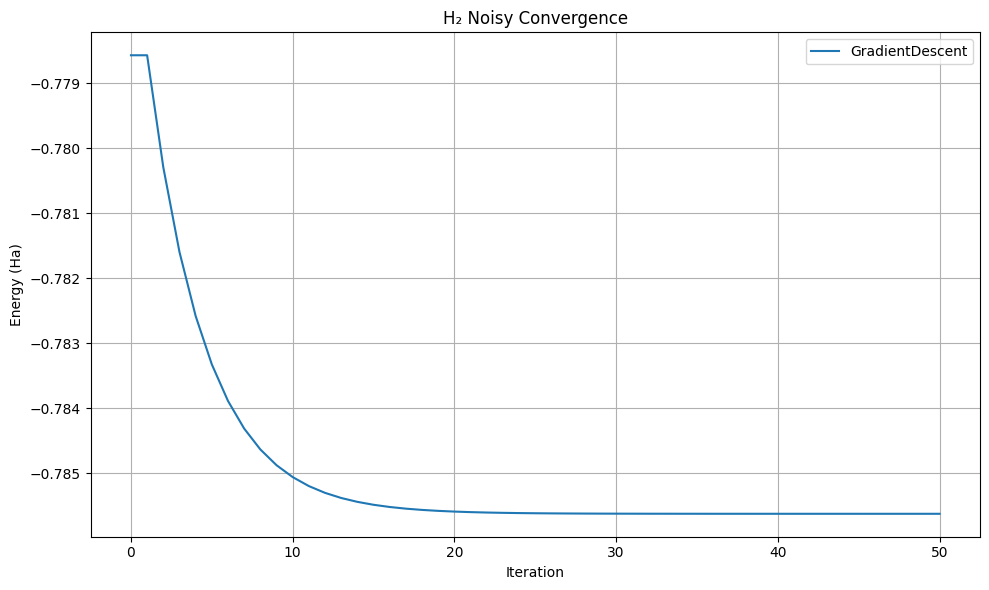

In [3]:
# Plot comparison of all optimizer energy curves
plt.figure(figsize=(10, 6))
for name, res in results.items():
    energies = res["energy"]
    plt.plot(range(len(energies)), energies, label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ Noisy Convergence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noisy.png", dpi=300)
plt.show()

In [4]:
print(f"{optimizer_name}:\nFinal ground state energy = {energies[-1]:.8f} Ha\n")

GradientDescent:
Final ground state energy = -0.78562477 Ha



In [5]:
# Choose optimizer with lowest final energy
# If ties occur at machine precision, this picks the first min encountered.
best_name = min(results, key=lambda n: results[n]["energy"][-1])
best_params = results[best_name]["params"]
print(f"Using best optimizer: {best_name}")


@qml.qnode(dev, diff_method="finite-diff")
def ground_state(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                      excitations=(singles, doubles), excitation_type="both")
    
    # Simple noise: 2% depolarizing, 4% amplitude damping
    for w in range(num_wires):
        qml.DepolarizingChannel(depolarizing_prob, wires=w)
        qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

    # Return the entire quantum statevector
    return qml.state()

final_rho = ground_state(best_params)  # Density matrix
diag_elements = np.diag(final_rho)

threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(diag_elements) > threshold)[0]
non_zero_values = diag_elements[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in enumerate(diag_elements):
    binary_state = f"|{idx:0{num_wires}b}⟩"
    if amp > threshold:
        ket_terms.append(f"({amp:.4f}|{idx:0{num_wires}b}⟩)")

ket_notation = " + ".join(ket_terms)
print(f"\nGround state of H₂ (diagonal of density matrix):\n|ψ⟩ = {ket_notation}")

Using best optimizer: GradientDescent

Ground state of H₂ (diagonal of density matrix):
|ψ⟩ = (0.0486+0.0000j|0100⟩) + (0.0486+0.0000j|1000⟩) + (0.8720+0.0000j|1100⟩) + (0.0113+0.0000j|1101⟩) + (0.0113+0.0000j|1110⟩)


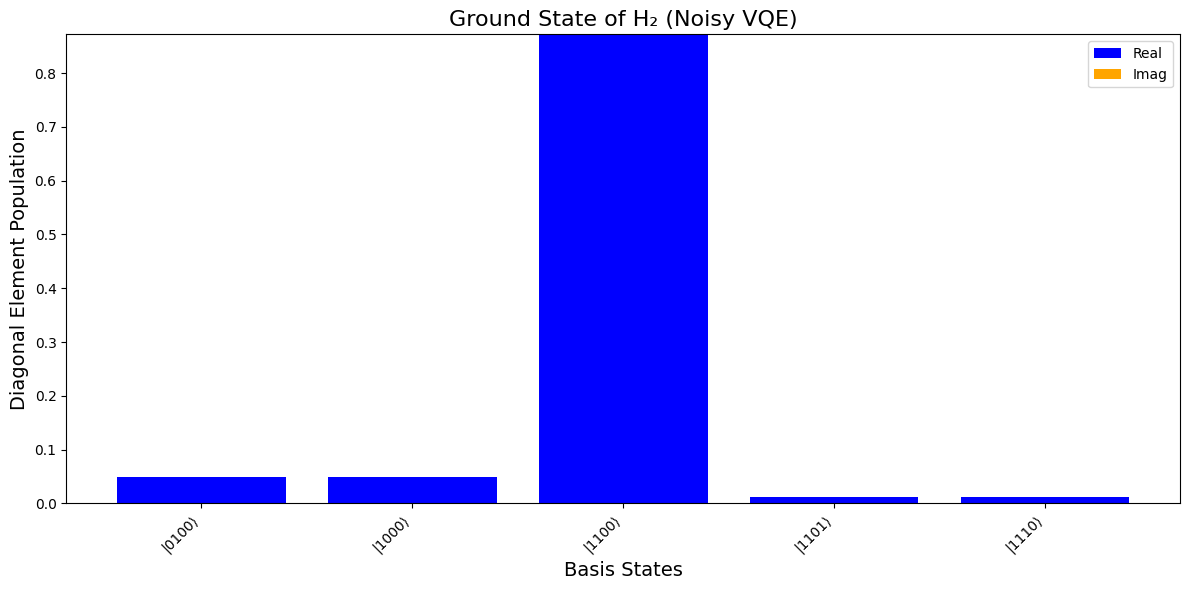

In [6]:
# Prepare labels and amplitudes for the plot
labels = [f"|{i:0{num_wires}b}⟩" for i in non_zero_indices]

# Bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, non_zero_values.real, color='blue', label='Real')
plt.bar(labels, non_zero_values.imag, color='orange', bottom=non_zero_values.real, label='Imag')
plt.xlabel('Basis States', fontsize=14)
plt.ylabel('Diagonal Element Population', fontsize=14)
plt.title('Ground State of H₂ (Noisy VQE)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noisy_Ground_State.png", dpi=300)
plt.show()